<a href="https://colab.research.google.com/github/JozJozmin/Churn-Prediction-ML/blob/main/Churn_Prediction_Improved_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### IMPORTING REQUIRED LIBRARIES FOR PLOTING AND BASIC OPERATIONS
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import numpy as np

sns.set_style('darkgrid')
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
%matplotlib inline

In [3]:
np.random.seed(0)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
### mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##   **Data Preparation and Cleaning** <br>

*   Loading the dataset into pandas dataframe. <br>
*   Checking the info. about data and columns 
*   Fixing the missing & incorrect values.

### 1. Loading the dataset into pandas dataframe

In [6]:
### Importing both the test and train data
test_df = pd.read_csv('/content/drive/MyDrive/Personal Projects /Churn Prediction improved model /test_lTY72QC.csv')
train_df = pd.read_csv('/content/drive/MyDrive/Personal Projects /Churn Prediction improved model /train_PDjVQMB.csv')

In [7]:
train_df.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


### 2. Checking the info. about data and columns

In [8]:
print(f' The shape of test data is;{test_df.shape}')
print(f' The shape of train data is;{train_df.shape}')

 The shape of test data is;(2851, 10)
 The shape of train data is;(6650, 11)


In [9]:
train_df.columns

Index(['ID', 'Age', 'Gender', 'Income', 'Balance', 'Vintage',
       'Transaction_Status', 'Product_Holdings', 'Credit_Card',
       'Credit_Category', 'Is_Churn'],
      dtype='object')

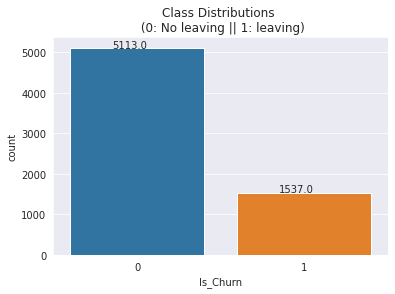

In [10]:
### checking the quantiy of no.s of zeros and ones in the target column of train_df

ax = sns.countplot('Is_Churn', data=train_df)
plt.title('Class Distributions \n (0: No leaving || 1: leaving)') 

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show() 

As we can see, this is an imbalanced dataset.

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Gender              6650 non-null   object 
 3   Income              6650 non-null   object 
 4   Balance             6650 non-null   float64
 5   Vintage             6650 non-null   int64  
 6   Transaction_Status  6650 non-null   int64  
 7   Product_Holdings    6650 non-null   object 
 8   Credit_Card         6650 non-null   int64  
 9   Credit_Category     6650 non-null   object 
 10  Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 571.6+ KB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2851 entries, 0 to 2850
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  2851 non-null   object 
 1   Age                 2851 non-null   int64  
 2   Gender              2851 non-null   object 
 3   Income              2851 non-null   object 
 4   Balance             2851 non-null   float64
 5   Vintage             2851 non-null   int64  
 6   Transaction_Status  2851 non-null   int64  
 7   Product_Holdings    2851 non-null   object 
 8   Credit_Card         2851 non-null   int64  
 9   Credit_Category     2851 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 222.9+ KB


In [13]:
### The column 'ID' is not required for the analysis 
del train_df['ID']
del test_df ['ID']

In [14]:
#### checking the range of details of each featurs in the given train_data
train_df.describe(include =['int64','float64'])

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn
count,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000
mean,41.130226,8.045954e+05,2.250226,0.515789,0.664361,0.231128
std,9.685747,5.157549e+05,1.458795,0.499788,0.472249,0.421586
min,21.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000
25%,34.000000,3.922642e+05,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.649386e+05,2.000000,1.000000,1.000000,0.000000
75%,47.000000,1.147124e+06,3.000000,1.000000,1.000000,0.000000
max,72.000000,2.436616e+06,5.000000,1.000000,1.000000,1.000000




*  The values in the balance column are high in range comapred to other features
*   In the Age column, the The 75% percentile and max value has high difference indicating the presence of outliers in the data. 



In [15]:
train_df.describe(include =['object'])

,Gender,Income,Product_Holdings,Credit_Category
count,6650,6650,6650,6650
unique,2,4,3,3
top,Male,10L - 15L,1,Poor
freq,3612,1885,3200,3076


In [16]:
### checking the details of test_df
test_df.describe(include =['int64','float64'])

,Age,Balance,Vintage,Transaction_Status,Credit_Card
count,2851.000000,2.851000e+03,2851.000000,2851.000000,2851.000000
mean,41.252192,8.098990e+05,2.220975,0.506840,0.668888
std,9.616756,5.252003e+05,1.489941,0.500041,0.470696
min,21.000000,1.503000e+03,0.000000,0.000000,0.000000
25%,34.000000,4.009684e+05,1.000000,0.000000,0.000000
50%,40.000000,7.659125e+05,2.000000,1.000000,1.000000
75%,47.000000,1.154238e+06,3.000000,1.000000,1.000000
max,72.000000,2.434834e+06,5.000000,1.000000,1.000000


In [17]:
test_df.describe(include =['object'])

,Gender,Income,Product_Holdings,Credit_Category
count,2851,2851,2851,2851
unique,2,4,3,3
top,Male,10L - 15L,2,Poor
freq,1545,844,1359,1270


### Missing Values

In [18]:
train_df.isna().sum()

Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

In [19]:
test_df.isna().sum()

Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
dtype: int64

Great! we don't have any missing values in the given datasets

## **Exploratory Analysis and Visualisation**
1. Univariate analysis 
2. Multivariate Analysis 

#### **Univariate Analysis** 

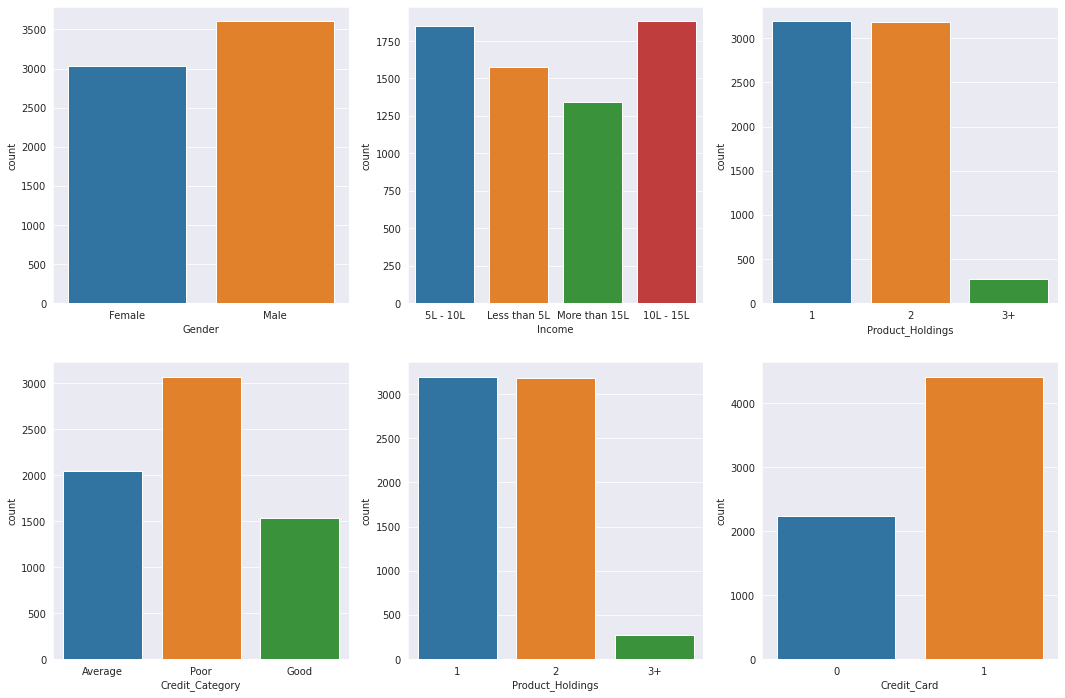

In [20]:
### plotting the catagorical columns.
fig, axs = plt.subplots(nrows = 2 , ncols = 3,figsize=(18, 12))
sns.countplot(x= 'Gender', data=train_df, ax = axs[0,0])
sns.countplot(x= 'Income', data=train_df, ax = axs[0,1])
sns.countplot(x= 'Product_Holdings', data=train_df, ax = axs[0,2])
sns.countplot(x= 'Credit_Category', data=train_df, ax = axs[1,0])
sns.countplot(x= 'Product_Holdings', data=train_df, ax = axs[1,1])
sns.countplot(x= 'Credit_Card', data=train_df, ax = axs[1,2])
plt.show()

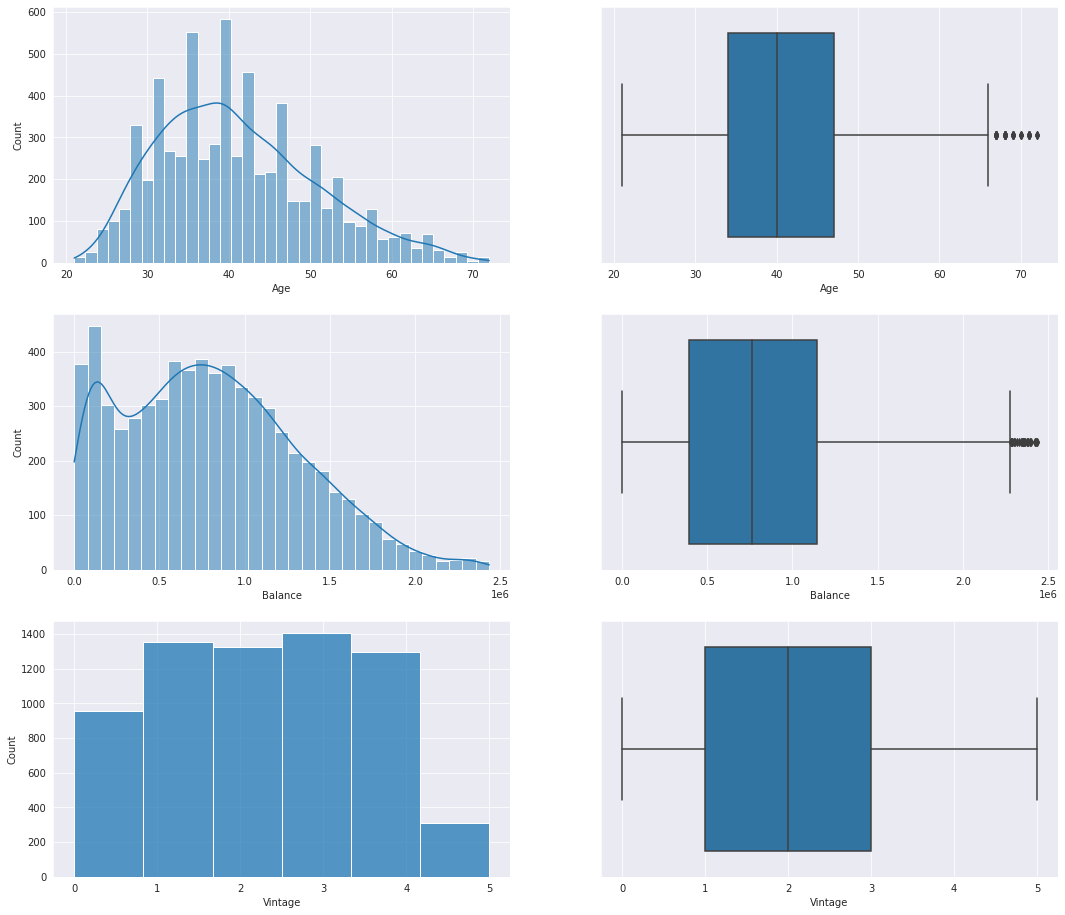

In [21]:
### plotting histograms & boxplot for both 'Age'& 'Balance' columns
fig, axs = plt.subplots(nrows = 3 , ncols = 2,figsize=(18, 16))
sns.histplot(x= 'Age', data=train_df,kde= True , ax = axs[0,0])
sns.histplot(x= 'Balance', data=train_df, kde=True,ax = axs[1,0])
sns.boxplot (x= 'Age', data=train_df, ax = axs[0,1])
sns.boxplot(x= 'Balance', data=train_df, ax = axs[1,1])
sns.histplot(x= 'Vintage', data=train_df, ax = axs[2,0],bins = 6)
sns.boxplot(x= 'Vintage', data=train_df, ax = axs[2,1])
plt.show()



*  As we can see in the histplot, both the Age and Balance colum consists of outliers in the data.
*  The balance column follows right skewed ditribution.
*   The Vintage column implies there are very less number of customers who stay in the same bank more than 4 years.





### **Bivariate analysis**



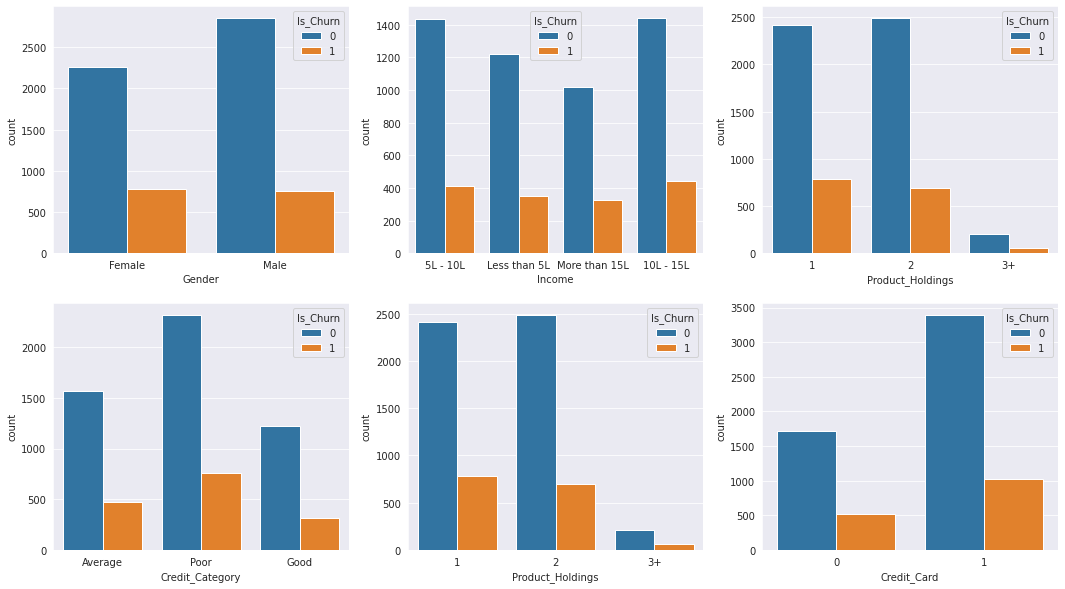

In [22]:
fig, axs = plt.subplots(nrows = 2 , ncols = 3,figsize=(18, 10))
sns.countplot(x= 'Gender', hue = 'Is_Churn',data=train_df, ax = axs[0,0])
sns.countplot(x= 'Income',hue = 'Is_Churn', data=train_df, ax = axs[0,1])
sns.countplot(x= 'Product_Holdings',hue = 'Is_Churn', data=train_df, ax = axs[0,2])
sns.countplot(x= 'Credit_Category',hue = 'Is_Churn', data=train_df, ax = axs[1,0])
sns.countplot(x= 'Product_Holdings',hue = 'Is_Churn', data=train_df, ax = axs[1,1])
sns.countplot(x= 'Credit_Card',hue = 'Is_Churn', data=train_df, ax = axs[1,2])
plt.show()

1. In both the gender almost equal amount of employees are likely to leave the Bank. 

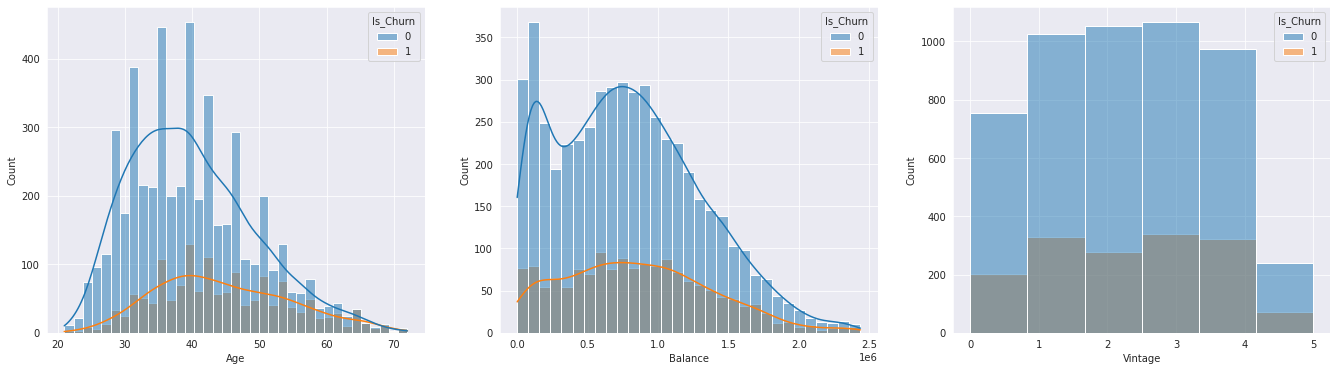

In [23]:
### plotting histograms & boxplot for both 'Age'& 'Balance' columns
fig, axs = plt.subplots(nrows = 1 , ncols = 3,figsize=(23, 6))
sns.histplot(x= 'Age',hue = 'Is_Churn', data=train_df,kde= True , ax = axs[0])
sns.histplot(x= 'Balance',hue = 'Is_Churn', data=train_df, kde=True,ax = axs[1])
sns.histplot(x= 'Vintage',hue = 'Is_Churn', data=train_df,bins = 6,ax = axs[2])
plt.show()


*   The employees who are in between 35-55 range are more likely to leave the bank.  



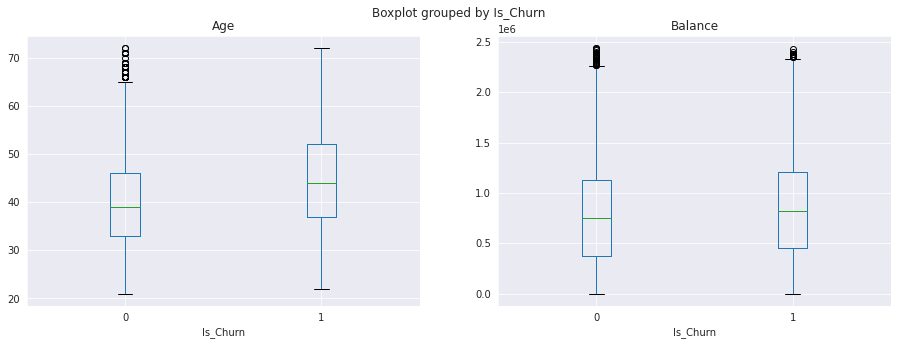

In [24]:
### with respect to the 'Is_Churn'column the the boxplot for 'Age' and 'Balance' column
list_of_feature = ['Age','Balance']
fig, axs = plt.subplots(ncols = 2,figsize=(15, 5))
for feature in list_of_feature:
    train_df.boxplot(column=feature, by='Is_Churn',ax = axs[list_of_feature.index(feature)])
    plt.title(feature)
plt.show()

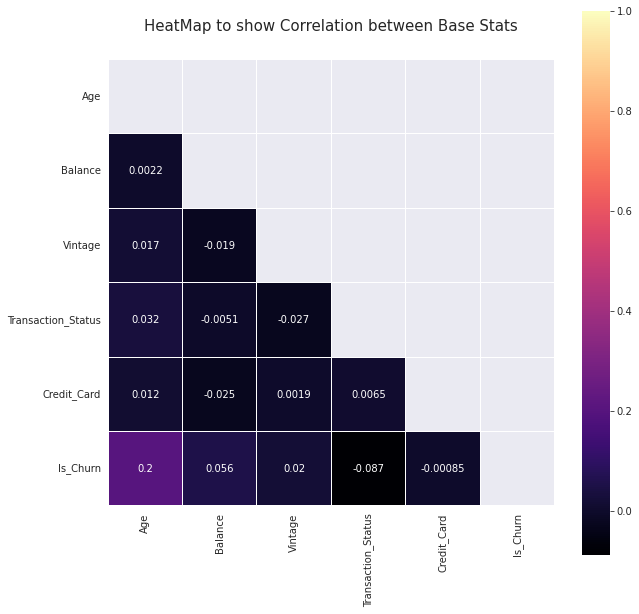

In [25]:
### correlation between independent varibles
mask = np.zeros_like(train_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
Corr = train_df
colormap = plt.cm.magma
plt.title('HeatMap to show Correlation between Base Stats', y=1.05, size=15)
sns.heatmap(Corr.corr(),linewidths=0.1,vmax=1, square=True, cmap=colormap, linecolor='white', annot=True,mask=mask)

None of the features are strongly correlated with the target varible 'Is_Churn'.

In [26]:
train_df.columns

Index(['Age', 'Gender', 'Income', 'Balance', 'Vintage', 'Transaction_Status',
       'Product_Holdings', 'Credit_Card', 'Credit_Category', 'Is_Churn'],
      dtype='object')

In [27]:
#Cheking Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
  
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [28]:
calc_vif(train_df[[i for i in train_df.describe().columns if i not in ['Is_Churn']]])

,variables,VIF
0,Age,6.579676
1,Balance,3.097499
2,Vintage,3.088312
3,Transaction_Status,2.000456
4,Credit_Card,2.765189


VIF values between 1 and 5 suggest that the correlation is not severe enough to warrant corrective measures. VIF value of Age columns is > 5 representing critical levels of multicollinearity where the coefficient estimates may not be trusted and the statistical significance is questionable.<br> 
So l will be trasnforming the age column by using RobustScaler function.

### **Outliers Detection & removel**

Both the Age and Balance column contains outliers. In order to remove the outliers & reduce VIF value in the age columns performing the binning for both the train and test dataset

In [29]:
# ### Performing binning and converting the age column into 10 discrete buckets
# train_df['Age_catagory'] = pd.cut(x=train_df['Age'], bins=[1, 25, 30, 35, 40,45,50,55,60,65,80],
#                      labels=['lessthan_25', '26-30','31-35','36-40','41 to 45','46-50','51-55','56-60',
#                            '61-65'  ,'greaterthan_66'])

# ### Performing same actions on test data
# test_df['Age_catagory'] = pd.cut(x=test_df['Age'] , bins=[1, 25, 30, 35, 40,45,50,55,60,65,80],
#                      labels=['lessthan_25', '26-30','31-35','36-40','41 to 45','46-50','51-55','56-60',
#                            '61-65'  ,'greaterthan_66'])

In [30]:
# train_df['Age_catagory'].dtype

In [31]:
# ### converting data type of newly created Age_catagory column
#train_df['Age_catagory'] = train_df['Age_catagory'].astype('object')
# test_df['Age_catagory']  = test_df['Age_catagory'] .astype('object')

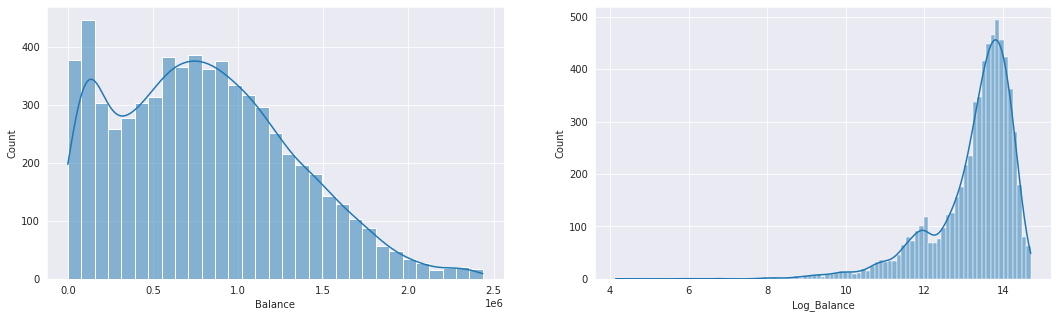

In [32]:
### Since the range of values in the Balance column is higher comapred to other features I am checking the log trasformation of Balance column.
train_df['Log_Balance'] = np.log(train_df['Balance'])
 
fig, axs = plt.subplots(ncols = 2,figsize=(18, 5))
sns.histplot(x= 'Balance', data=train_df,kde= True , ax = axs[0])
sns.histplot(x= 'Log_Balance', data=train_df, kde=True,ax = axs[1])

In [33]:
calc_vif(train_df[[i for i in train_df.describe().columns if i not in ['Is_Churn','Balance']]])

,variables,VIF
0,Age,17.324829
1,Vintage,3.323295
2,Transaction_Status,2.059435
3,Credit_Card,2.934501
4,Log_Balance,20.720171


The transformaed log column is showing higer VIF value in this data. So instead of transforming the Balance column by log, I will try using RobustScaler which can deal with the outliers in the Balance column.

In [34]:
### dropping the log transformed column
train_df.drop('Log_Balance',axis = 1, inplace = True)

### OVERSAMPLING

In [35]:
count_class_0, count_class_1 = train_df.Is_Churn.value_counts()

In [36]:
# Divide by class
train_df_class_0 = train_df[train_df['Is_Churn'] == 0]
train_df_class_1 = train_df[train_df['Is_Churn'] == 1]

In [37]:
print(train_df_class_0 .shape)
print(train_df_class_1 .shape)

(5113, 10)
(1537, 10)


In [38]:
### Oversample 1-class and concat the DataFrames of both classes
train_df_class_1_over = train_df_class_1.sample(count_class_0, replace=True)
new_train_df = pd.concat([train_df_class_0, train_df_class_1_over ], axis=0)

print('Random over-sampling:')
print(new_train_df.Is_Churn.value_counts())

Random over-sampling:
0    5113
1    5113
Name: Is_Churn, dtype: int64


In [39]:
new_train_df.shape

(10226, 10)

In [40]:
new_train_df.columns

Index(['Age', 'Gender', 'Income', 'Balance', 'Vintage', 'Transaction_Status',
       'Product_Holdings', 'Credit_Card', 'Credit_Category', 'Is_Churn'],
      dtype='object')

### splitting train and test data 

In [41]:
#input_col = [ 'Age_catagory', 'Gender', 'Income', 'log_Balance', 'Vintage','Transaction_Status', 'Product_Holdings', 'Credit_Card','Credit_Category']
input_col = ['Age','Gender', 'Income', 'Vintage','Transaction_Status', 'Product_Holdings', 'Credit_Card','Credit_Category','Balance']

### Identifying target column
target_col = 'Is_Churn'

In [42]:
#### importing required libraries for Data splitting for training & Validation 
from sklearn.model_selection import train_test_split

### taking 25% of training data as validating data 
X_train_df , X_val_df = train_test_split(new_train_df, test_size=0.25, random_state=5,stratify =new_train_df['Is_Churn'])

In [43]:
### Identifying target column
target_col = 'Is_Churn'

### inputs and targets for the training 
X_train = X_train_df[input_col]
y_train = X_train_df[target_col]

### Inputs and targets for the validation
X_val = X_val_df[input_col]
y_val = X_val_df[target_col]

### final testing data 
X_test = test_df[input_col]

### **Seperating catagorical and numeric data**

In [44]:
#### Identfying  numerical and categorical columns in the data
numeric_cols = train_df[input_col].select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df[input_col].select_dtypes('object').columns.tolist()

In [45]:
train_df[categorical_cols].head()

,Gender,Income,Product_Holdings,Credit_Category
0,Female,5L - 10L,1,Average
1,Female,Less than 5L,1,Poor
2,Female,More than 15L,2,Poor
3,Female,More than 15L,2,Poor
4,Female,More than 15L,1,Good


In [46]:
train_df[categorical_cols].nunique()

Gender              2
Income              4
Product_Holdings    3
Credit_Category     3
dtype: int64

In [47]:
train_df[numeric_cols].head()

,Age,Vintage,Transaction_Status,Credit_Card,Balance
0,36,4,0,0,563266.44
1,53,2,1,1,875572.11
2,35,2,1,0,701607.06
3,43,0,1,1,1393922.16
4,39,1,1,1,893146.23


### **Scaling Numeric Features**

Since MinMax Scaler is more sensetive to the outliers present in the features, I am using Robust Scaler for Both the Age and Balance columns. And normal MinMax Scaler for Vintage column which doesnot consists of any outliers.

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#scaler.fit(train_df[['Age','Vintage','Balance']])
scaler.fit(train_df[['Vintage']])

MinMaxScaler()

In [49]:
X_train[['Vintage']] = scaler.transform(X_train[['Vintage']])
X_val[['Vintage']] = scaler.transform(X_val[['Vintage']])
X_test[['Vintage']] = scaler.transform(X_test[['Vintage']])

In [50]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(train_df[['Age','Balance']])

RobustScaler()

In [51]:
X_train[['Age','Balance']] = scaler.transform(X_train[['Age','Balance']])
X_val[['Age','Balance']] = scaler.transform(X_val[['Age','Balance']])
X_test[['Age','Balance']] = scaler.transform(X_test[['Age','Balance']])

In [52]:
X_train[numeric_cols].describe()

,Age,Vintage,Transaction_Status,Credit_Card,Balance
count,7669.000000,7669.000000,7669.000000,7669.000000,7669.000000
mean,0.181610,0.458391,0.485331,0.668796,0.083960
std,0.765917,0.291966,0.499817,0.470677,0.690957
min,-1.461538,0.000000,0.000000,0.000000,-1.013269
25%,-0.384615,0.200000,0.000000,0.000000,-0.447059
50%,0.076923,0.400000,0.000000,1.000000,0.026030
75%,0.692308,0.800000,1.000000,1.000000,0.544205
max,2.461538,1.000000,1.000000,1.000000,2.214554


In [53]:
calc_vif(X_train[[i for i in X_train.describe().columns if i not in ['Is_Churn']]])

,variables,VIF
0,Age,1.054528
1,Vintage,2.141501
2,Transaction_Status,1.642878
3,Credit_Card,2.124213
4,Balance,1.011445


Great! All the VIF values for the numerical columns are <5 

### **Encoding Categorical Data**

In [54]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

In [55]:
encoder.fit(train_df[categorical_cols])

OneHotEncoder(sparse=False)

In [56]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['10L - 15L', '5L - 10L', 'Less than 5L', 'More than 15L'],
       dtype=object),
 array(['1', '2', '3+'], dtype=object),
 array(['Average', 'Good', 'Poor'], dtype=object)]

In [57]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))
print(encoded_cols)

['Gender_Female', 'Gender_Male', 'Income_10L - 15L', 'Income_5L - 10L', 'Income_Less than 5L', 'Income_More than 15L', 'Product_Holdings_1', 'Product_Holdings_2', 'Product_Holdings_3+', 'Credit_Category_Average', 'Credit_Category_Good', 'Credit_Category_Poor']


In [58]:
X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
X_val[encoded_cols] = encoder.transform(X_val[categorical_cols])
X_test[encoded_cols] = encoder.transform(X_test[categorical_cols])

In [59]:
### droping repeating gender columns
X_train[encoded_cols].columns

Index(['Gender_Female', 'Gender_Male', 'Income_10L - 15L', 'Income_5L - 10L',
       'Income_Less than 5L', 'Income_More than 15L', 'Product_Holdings_1',
       'Product_Holdings_2', 'Product_Holdings_3+', 'Credit_Category_Average',
       'Credit_Category_Good', 'Credit_Category_Poor'],
      dtype='object')

In [60]:
X_train[numeric_cols].columns

Index(['Age', 'Vintage', 'Transaction_Status', 'Credit_Card', 'Balance'], dtype='object')

In [61]:
X_train = X_train[numeric_cols + encoded_cols].drop(['Gender_Female'],axis = 1)
X_val = X_val[numeric_cols + encoded_cols].drop(['Gender_Female'],axis = 1)
X_test = X_test[numeric_cols + encoded_cols].drop(['Gender_Female'],axis = 1)

In [62]:
X_train.columns

Index(['Age', 'Vintage', 'Transaction_Status', 'Credit_Card', 'Balance',
       'Gender_Male', 'Income_10L - 15L', 'Income_5L - 10L',
       'Income_Less than 5L', 'Income_More than 15L', 'Product_Holdings_1',
       'Product_Holdings_2', 'Product_Holdings_3+', 'Credit_Category_Average',
       'Credit_Category_Good', 'Credit_Category_Poor'],
      dtype='object')

In [63]:
X_train.shape

(7669, 16)

In [64]:
X_val.shape

(2557, 16)

In [65]:
X_test.shape

(2851, 16)

### **Model Fitting & Model Evaluation**

Models used for this data:

*   Logistic Regression
*   K-Nearest Neighbors (KNN)
*   Support Vector Machine
*   Decision Tree
*   Naive Bayes

In [66]:
### Generic function for fitting and checking accuracy by KFold cross validation
def modelfit(model, X, y, k, X_val,y_val, X_test):
    
    ### KFold cross-validation
    kf = model_selection.KFold(n_splits=k, random_state=None)
    result = cross_val_score(model , X, y, cv = kf , scoring='f1_macro')
    
    print("\nModel Results")
    print("CV Score : Mean - %.3g \nStd - %.3g \nMin - %.3g \nMax- %.3g" % (np.mean(result),np.std(result),np.min(result),np.max(result)))
    
    ### Fitting
    model.fit(X, y)
    
    ### Prediction of train data
    Y_pred_train = model.predict(X)

    ### Model Evaluation Metrics
    accuracy_train = accuracy_score(y_train,Y_pred_train)
    precision = precision_score(y,Y_pred_train, average='binary')
    recall = recall_score(y,Y_pred_train, average='binary')
    macro_f1_score = f1_score(y, Y_pred_train, average='macro')
    conf_matrix = confusion_matrix(y,Y_pred_train, normalize='true')

    print('\nEvaluation Metrics- training data')
    print(f"Accuracy :{round(accuracy_train,3)} \nPrecision :{round(precision,3)} \nRecall : {round(recall,3)} \nMacro F1 score: {round(macro_f1_score,3)} \nConfusion matrix: {conf_matrix}")

    ### predicting the validation data 
    Y_pred_val = model.predict(X_val)

    print('\nEvaluation Metrics- Validating data')
    accuracy_val = accuracy_score(y_val,Y_pred_val)
    print(f"Accuracy of validating data :{round(accuracy_val,3)}")    
    ### Predict on testing data:
    Y_pred = model.predict(X_test)
    return Y_pred

### Model 1 - Logistic Regression

In [83]:
# Logistic Regression 
Log_reg = LogisticRegression(C = 0.2)
Y_pred = modelfit(Log_reg, X_train, y_train, 5,X_val,y_val, X_test)


Model Results
CV Score : Mean - 0.605 
Std - 0.0103 
Min - 0.594 
Max- 0.624

Evaluation Metrics- training data
Accuracy :0.609 
Precision :0.614 
Recall : 0.583 
Macro F1 score: 0.608 
Confusion matrix: [[0.63363755 0.36636245]
 [0.41653625 0.58346375]]

Evaluation Metrics- Validating data
Accuracy of validating data :0.608


In [68]:
### Logistic Regression Model - Hyper parameter tuning
# defining parameter range
param_grid = {'C': np.logspace(-1, 1, 15)} 
  
grid_LR = GridSearchCV(LogisticRegression(), param_grid, verbose = 3,scoring='f1_macro',cv=3)
  
# fitting the model for grid search
grid_LR.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END .............................C=0.1;, score=0.607 total time=   0.1s
[CV 2/3] END .............................C=0.1;, score=0.604 total time=   0.1s
[CV 3/3] END .............................C=0.1;, score=0.597 total time=   0.2s
[CV 1/3] END .............C=0.13894954943731375;, score=0.607 total time=   0.1s
[CV 2/3] END .............C=0.13894954943731375;, score=0.603 total time=   0.1s
[CV 3/3] END .............C=0.13894954943731375;, score=0.597 total time=   0.1s
[CV 1/3] END ...............C=0.193069772888325;, score=0.608 total time=   0.1s
[CV 2/3] END ...............C=0.193069772888325;, score=0.603 total time=   0.1s
[CV 3/3] END ...............C=0.193069772888325;, score=0.597 total time=   0.2s
[CV 1/3] END ..............C=0.2682695795279726;, score=0.609 total time=   0.1s
[CV 2/3] END ..............C=0.2682695795279726;, score=0.603 total time=   0.1s
[CV 3/3] END ..............C=0.2682695795279726;

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([ 0.1       ,  0.13894955,  0.19306977,  0.26826958,  0.37275937,
        0.51794747,  0.71968567,  1.        ,  1.38949549,  1.93069773,
        2.6826958 ,  3.72759372,  5.17947468,  7.19685673, 10.        ])},
             scoring='f1_macro', verbose=3)

In [69]:
# print best parameter after tuning
print(grid_LR.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid_LR.best_estimator_)

{'C': 0.372759372031494}
LogisticRegression(C=0.372759372031494)


In [70]:
# Logistic Regression with L1 regularisation 
Log_reg_1 = LogisticRegression(C=3.72759372031494,penalty = 'l1',solver='liblinear')
Y_pred = modelfit(Log_reg_1, X_train, y_train, 5,X_val,y_val, X_test)


Model Results
CV Score : Mean - 0.606 
Std - 0.0105 
Min - 0.594 
Max- 0.625

Evaluation Metrics- training data
Accuracy :0.608 
Precision :0.614 
Recall : 0.583 
Macro F1 score: 0.608 
Confusion matrix: [[0.63363755 0.36636245]
 [0.41679708 0.58320292]]

Evaluation Metrics- Validating data
Accuracy of validating data :0.608


In [71]:
# Logistic Regression with L1 regularisation 
Log_reg_1 = LogisticRegression(C=3.72759372031494,penalty = 'l2',solver='liblinear')
Y_pred = modelfit(Log_reg_1, X_train, y_train, 5,X_val,y_val, X_test)


Model Results
CV Score : Mean - 0.605 
Std - 0.011 
Min - 0.594 
Max- 0.626

Evaluation Metrics- training data
Accuracy :0.609 
Precision :0.614 
Recall : 0.585 
Macro F1 score: 0.608 
Confusion matrix: [[0.63285528 0.36714472]
 [0.41549296 0.58450704]]

Evaluation Metrics- Validating data
Accuracy of validating data :0.609


### Model 2 - K-Nearest Neighbors (KNN)

In [72]:
### K-Nearest Neighbors (KNN)
Knn = KNeighborsClassifier(n_neighbors = 3,metric = 'euclidean',weights='uniform' )
Y_pred = modelfit(Knn, X_train, y_train, 5,X_val,y_val, X_test)


Model Results
CV Score : Mean - 0.701 
Std - 0.0145 
Min - 0.675 
Max- 0.718

Evaluation Metrics- training data
Accuracy :0.87 
Precision :0.817 
Recall : 0.955 
Macro F1 score: 0.869 
Confusion matrix: [[0.78591917 0.21408083]
 [0.04512259 0.95487741]]

Evaluation Metrics- Validating data
Accuracy of validating data :0.726


### Model 3 - Support Vector Machine

In [73]:
### Support Vector Machine - Hyper paramter tuning
# defining parameter range
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,scoring='f1_macro',cv=3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.609 total time=   2.9s
[CV 2/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.598 total time=   1.5s
[CV 3/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.602 total time=   1.2s
[CV 1/3] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.609 total time=   1.2s
[CV 2/3] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.598 total time=   1.2s
[CV 3/3] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.602 total time=   1.1s
[CV 1/3] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.609 total time=   1.2s
[CV 2/3] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.598 total time=   1.2s
[CV 3/3] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.602 total time=   1.2s
[CV 1/3] END .C=0.1, gamma=0.001, kernel=linear;, score=0.609 total time=   1.2s
[CV 2/3] END .C=0.1, gamma=0.001, kernel=linear;, score=0.598 total time=   1.2s
[CV 3/3] END .C=0.1, gamma=0.001, kernel=linear;

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear']},
             scoring='f1_macro', verbose=3)

In [74]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1, gamma=1, kernel='linear')


In [75]:
### Support Vector Machine with tuned parameters
from sklearn import svm
svc = grid.best_estimator_
Y_pred1 = modelfit(svc, X_train, y_train, 5,X_val,y_val, X_test)


Model Results
CV Score : Mean - 0.605 
Std - 0.0112 
Min - 0.593 
Max- 0.625

Evaluation Metrics- training data
Accuracy :0.605 
Precision :0.615 
Recall : 0.56 
Macro F1 score: 0.604 
Confusion matrix: [[0.64928292 0.35071708]
 [0.44027126 0.55972874]]

Evaluation Metrics- Validating data
Accuracy of validating data :0.599


### Model 4 -Decision Tree 

In [76]:
# from sklearn.tree import DecisionTreeClassifier
# # defining parameter range
# param_grid =  {'splitter' : ['best', 'random'],
# 'criterion' : ['gini', 'entropy'],
# 'max_features': ['log2', 'sqrt','auto'],
# 'max_depth': [2, 3, 5, 10, 17],
# 'min_samples_split': [2, 3, 5, 7, 9],
# 'min_samples_leaf': [1,5,8,11],
# 'random_state' : [0,1,2,3,4,5]
# }
  
# grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 3,scoring='f1_macro',cv=3)
  
# # fitting the model for grid search
# grid.fit(X_train, y_train)

In [77]:
# # print best parameter after tuning
# print(grid.best_params_)
  
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)

But I am not using this parameters since I found that this parameters result in overfitting the model

In [78]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier  
classifier_DT= DecisionTreeClassifier(random_state=5, max_depth= 9, max_features="auto", min_samples_split= 4, class_weight={0:0.3, 1:0.7},splitter='best') 
Y_pred = modelfit(classifier_DT, X_train, y_train, 5,X_val,y_val, X_test)


Model Results
CV Score : Mean - 0.561 
Std - 0.0281 
Min - 0.507 
Max- 0.584

Evaluation Metrics- training data
Accuracy :0.659 
Precision :0.599 
Recall : 0.961 
Macro F1 score: 0.624 
Confusion matrix: [[0.3559322  0.6440678 ]
 [0.03860198 0.96139802]]

Evaluation Metrics- Validating data
Accuracy of validating data :0.619


In [79]:
# Decision Tree Classifier with different hyper paramters 
from sklearn.tree import DecisionTreeClassifier  
classifier_DT_1= DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=0,class_weight={0:0.7, 1:0.7}) 
Y_pred = modelfit(classifier_DT_1, X_train, y_train, 5,X_val,y_val, X_test)


Model Results
CV Score : Mean - 0.619 
Std - 0.015 
Min - 0.599 
Max- 0.637

Evaluation Metrics- training data
Accuracy :0.66 
Precision :0.648 
Recall : 0.701 
Macro F1 score: 0.659 
Confusion matrix: [[0.61929596 0.38070404]
 [0.29916536 0.70083464]]

Evaluation Metrics- Validating data
Accuracy of validating data :0.61


In [84]:
# Decision Tree Classifier with different hyper paramters 
from sklearn.tree import DecisionTreeClassifier  
classifier_DT_1= DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=0,class_weight={0:0.7, 1:0.7}) 
Y_pred = modelfit(classifier_DT_1, X_train, y_train, 5,X_val,y_val, X_test)


Model Results
CV Score : Mean - 0.618 
Std - 0.012 
Min - 0.6 
Max- 0.632

Evaluation Metrics- training data
Accuracy :0.653 
Precision :0.648 
Recall : 0.671 
Macro F1 score: 0.653 
Confusion matrix: [[0.63520209 0.36479791]
 [0.32916015 0.67083985]]

Evaluation Metrics- Validating data
Accuracy of validating data :0.601


### Model 5 - Naive Bayes

In [80]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB
gaussian = GaussianNB()
Y_pred = modelfit(gaussian, X_train, y_train, 5,X_val,y_val, X_test)


Model Results
CV Score : Mean - 0.593 
Std - 0.00644 
Min - 0.587 
Max- 0.605

Evaluation Metrics- training data
Accuracy :0.598 
Precision :0.604 
Recall : 0.57 
Macro F1 score: 0.598 
Confusion matrix: [[0.62685789 0.37314211]
 [0.43009911 0.56990089]]

Evaluation Metrics- Validating data
Accuracy of validating data :0.596
